# Hydro ANN 

### Load and preprocess data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Hydro','Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_64624\2660157751.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')


In [3]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Hydro'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [4]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Hydro'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Hydro'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [6]:
# Large computation 
data['Previous_Year_Hydro'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [7]:
cutoff_date = pd.to_datetime("2023-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Hydro','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [8]:


usable_data['Previous_Day_Hydro'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Hydro'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [9]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Year'] = usable_data['BeginDate'].dt.year
usable_data['Month'] = usable_data['BeginDate'].dt.month
features = usable_data[['Month','Previous_Day_Hydro','Previous_2Day_Hydro','Sum','Hour_of_Day','Previous_Year_Hydro','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]

# Useless Features , ,
target = usable_data['Hydro']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (93643, 18)
Target shape:  (93643,)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=80, validation_split=0.15, batch_size=32)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/80


C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1990/1990 ━━━━━━━━━━━━━━━━━━━━ 2s 622us/step - loss: 244917.8906 - val_loss: 38176.5078
Epoch 2/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - loss: 36933.2188 - val_loss: 33392.2031
Epoch 3/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 34199.5195 - val_loss: 31306.8145
Epoch 4/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - loss: 31566.6797 - val_loss: 30066.4453
Epoch 5/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - loss: 30018.0000 - val_loss: 28127.7461
Epoch 6/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 28231.9082 - val_loss: 27266.1699
Epoch 7/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - loss: 27520.6562 - val_loss: 26483.2344
Epoch 8/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step - loss: 26318.4707 - val_loss: 25372.0098
Epoch 9/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 25656.1367 - val_loss: 24295.8281
Epoch 10/80
1990/1990 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - loss: 24335.2168 - val_loss: 23925.5098
Epoch 11/80
1990/1990 ━━━━━━━

### Analysis

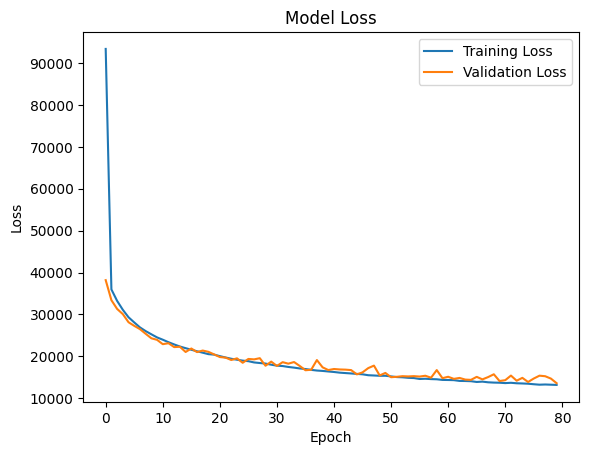

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [16]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
Predicted Solar Energy Ouput: [863.0565185546875, 516.1699829101562, 1017.0517578125, 1977.2646484375, 1082.1798095703125, 870.0650024414062, 1374.2562255859375, 1163.2589111328125, 688.3968505859375, 1134.792724609375, 634.8021240234375, 2216.30322265625, 406.0157470703125, 1574.2237548828125, 631.223388671875, 746.6298828125, 1126.5096435546875, 1354.2086181640625, 327.1208801269531, 2241.458984375]
Actual Solar Energy Output: [ 789.  549. 1054. 1882. 1088.  740. 1413. 1268.  604. 1306.  551. 2106.
  278. 1613.  624.  659. 1131. 1364.  257. 2189.]


In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 83.99656244388247
Mean Squared Error (MSE): 13906.794991214976
Root Mean Squared Error (RMSE): 117.92707488619811
Percent Error (PERR): 0.09144965301238073


### Save model

In [18]:
model.save('HydroModel.h5')